In [1]:
{-# LANGUAGE FlexibleContexts, MonadComprehensions, NoImplicitPrelude, RebindableSyntax, TypeFamilies #-}
import Language.Stochaskell
stochaskell

Stochaskell, version 0.1.0
Copyright (C) 2015-2020 David A Roberts
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under certain conditions; see the LICENSE for details.

Using installation directory at 
  /home/jovyan/stochaskell

In [2]:
:opt svg
import Language.Stochaskell.Plot

In [3]:
binomial :: Z -> R -> P Z
binomial n p = do
  b <- joint vector [ bernoulli p | i <- 1...n ] :: P BVec
  let x = vector [ if (b!i) then 1 else 0 | i <- 1...n ]
  return (sum' x)

In [4]:
simulate (binomial 100 0.8)

79

In [5]:
negbin :: Z -> R -> P Z
negbin n p = do
  u <- joint vector [ uniform 0 1 | i <- 1...n ] :: P RVec
  let c = log (1 - p)
      y = vector [ floor' (log (u!i) / c) | i <- 1...n ]
      x = sum' y
  return x

In [6]:
simulate (negbin 100 0.8)

26

In [7]:
negbinFast :: Z -> R -> P Z
negbinFast n p = do
  l <- gamma (cast n) (p / (1-p))
  x <- poisson l
  return x

In [8]:
simulate (negbinFast 100 0.8)

23

In [9]:
poiLarge :: R -> P Z
poiLarge l = do
  let m = floor' ((7/8) * l)
  y <- gamma (cast m) 1
  if y <= l then do
    z <- poisson (l - y)
    let x = m + z
    return x
  else do
    x <- binomial (m - 1) (l / y)
    return x

In [10]:
simulate (poiLarge 101)

101

In [11]:
poiLogistic :: R -> P Z
poiLogistic l = do
  let s = pi / sqrt (3 * l)
      m = l * s
      c = 0.767 - 3.36/l
      k = log c - l - log s
  x <- truncated (-0.5) infinity (logistic (m/s) (1/s))
  let n = floor' (x + 0.5)
  v <- uniform 0 1
  guard $ m - s * x + log (v / (1 + exp (m - s * x))^2) <= k + cast n * log l - logFactorial' n
  return n

In [12]:
simulate (poiLogistic 10)

9

rejecting OOB sample -1.8440056765689814
rejecting OOB sample -0.8881852824008121
rejecting OOB sample -5.140704062106495
rejecting OOB sample -1.018521059768828
rejecting OOB sample -3.5482980173102856
rejecting OOB sample -1.1987218281037428
rejecting OOB sample -1.7500173852753775
rejecting OOB sample -0.8943314774080431
rejecting OOB sample -2.062286738501262
rejecting OOB sample -4.297006457246283
rejecting OOB sample -0.9501883821484736
rejecting OOB sample -0.9579324285374984
rejecting OOB sample -1.97607946315917
rejecting OOB sample -0.775368246955841
rejecting OOB sample -1.5672858182083953
rejecting OOB sample -3.6171568047541705
rejecting OOB sample -4.5419694857487105
rejecting OOB sample -3.775039060447236
rejecting OOB sample -1.2944092855424785
rejecting OOB sample -0.9427114697923038
rejecting OOB sample -2.0271562994774435
rejecting OOB sample -0.5315225281515676
rejecting OOB sample -1.817217482597405
rejecting OOB sample -0.6444665098958602
rejecting OOB sample -1.7

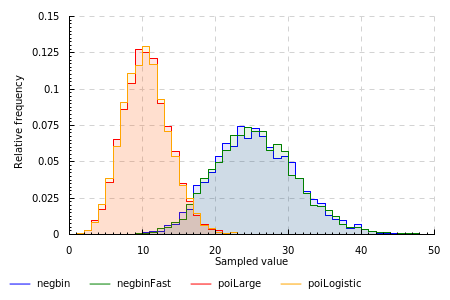

In [13]:
plots <- sequence <$> sequence
  [ plotP (negbin 100 0.8) 5000 "negbin"
  , plotP (negbinFast 100 0.8) 5000 "negbinFast"
  , plotP (poiLarge 10) 5000 "poiLarge"
  , plotP (poiLogistic 10) 5000 "poiLogistic"
  ]
toRenderable $ do
  plots
  xlabel "Sampled value"
  ylabel "Relative frequency"

In [14]:
cauchy :: P R
cauchy = do
  u <- uniform 0 1; v' <- uniform 0 1
  let v = v' - 1/2
  guard $ u^2 + v^2 <= 1
  let x = v/u
  return x

In [15]:
simulate cauchy

1.4966835223431374

In [16]:
gamma1 :: R -> P R
gamma1 a = do
  let b = a - 1
      c = a + b
  u <- uniform 0 1
  let y = sqrt c * tan (pi * (u - 1/2))
      x = b + y
  guard $ x >= 0
  v <- uniform 0 1
  guard $ v <= exp (b * log (x/b) - y +
                    log (1 + y^2 / c))
  return x

In [17]:
simulate (gamma1 10)

12.81317897956328

In [18]:
gammaBest :: R -> P R
gammaBest a = do
  let d = 0.07 + 0.75 * sqrt (1 - a)
      b = 1 + exp (-d) * a / d
  u1 <- uniform 0 1
  u2 <- uniform 0 1
  let v = b * u1
  if v <= 1 then do
    let x = d * v**(1/a)
    guard $ u2 <= (2 - x) / (2 + x) || u2 <= exp (-x)
    return x
  else do
    let x = -log (d * (b - v) / a)
        y = x / d
    guard $ u2 * (a + y * (1 - a)) <= 1 || u2 < y**(a - 1)
    return x

In [19]:
simulate (gammaBest 0.3)

0.114199317094991

In [20]:
normalSqueeze :: P R
normalSqueeze = do
  let a = sqrt (2 / exp 1)
  u <- uniform 0 1
  v <- uniform (-a) a
  let x = v/u
  guard $ (x^2 <= (6 - 8*u + 2*u^2))
       || (not (x^2 >= 2/u - 2*u)
           && (x^2 <= -4 * log u))
  return x

In [21]:
simulate normalSqueeze

1.9924728891739705

truncated: program does not appear to be primitive, falling back to guard

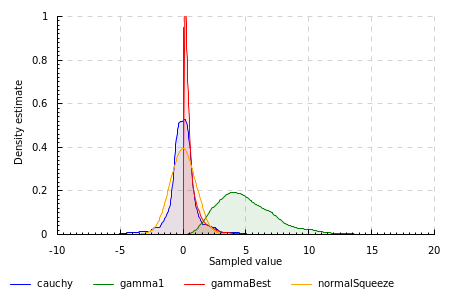

In [22]:
plots <- sequence <$> sequence
  [ plotP (truncated (-5) 5 cauchy) 5000 "cauchy"
  , plotP (gamma1 5) 5000 "gamma1"
  , plotP' (gammaBest 0.5) 5000 "gammaBest"
  , plotP normalSqueeze 5000 "normalSqueeze"
  , return (ylim (0,1))
  ]
toRenderable $ do
  plots
  xlabel "Sampled value"
  ylabel "Density estimate"